# Webcam Painting

In [1]:
import ipywidgets
import numpy as np
import cv2 as cv
from PIL import Image

## Setting up a webcam

In [9]:
from io import BytesIO
import IPython.display
import PIL.Image

def camera_capture():
    camera = cv.VideoCapture(0)
    camera.set(3, 640)
    camera.set(4, 480)
    ret, image = camera.read()

    if not ret:
        return None

    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    camera.release()
    return image

def camera_stream(process=lambda frame: frame):
    camera = cv.VideoCapture(0)
    camera.set(3, 640)
    camera.set(4, 480)
    try: 
        while True:
            ret, frame = camera.read()
            frame = process(frame)
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)

            stream = BytesIO()
            PIL.Image.fromarray(frame).save(stream, format="jpeg")
            IPython.display.display(IPython.display.Image(data=stream.getvalue()))

            IPython.display.clear_output(wait=True)
    except KeyboardInterrupt:
        camera.release()
        print("Stream Stopped")

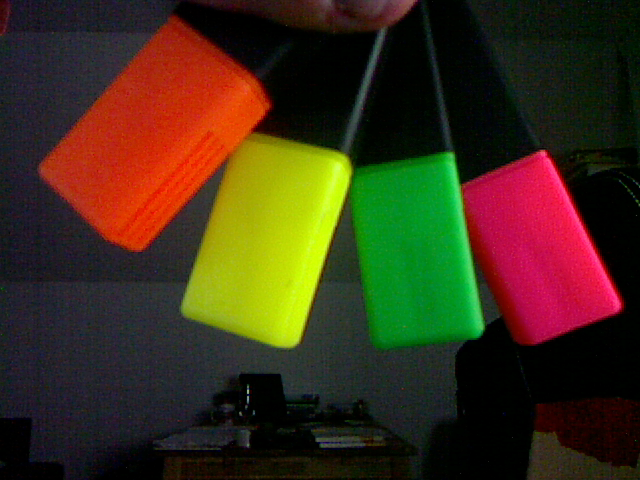

In [39]:
Image.fromarray(camera_capture())

## Finding HSV ranges for highlighters

In [10]:
cv.namedWindow("Controls")
cv.resizeWindow("Controls", 640, 350)
cv.createTrackbar("Min H", "Controls", 0, 200, lambda _: None)
cv.createTrackbar("Max H", "Controls", 0, 200, lambda _: None)
cv.createTrackbar("Min S", "Controls", 0, 255, lambda _: None)
cv.createTrackbar("Max S", "Controls", 0, 255, lambda _: None)
cv.createTrackbar("Min V", "Controls", 0, 255, lambda _: None)
cv.createTrackbar("Max V", "Controls", 0, 255, lambda _: None)

img = cv.imread("colors.png")
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

color = ipywidgets.Label()
display(color)

while True:
    h0 = cv.getTrackbarPos("Min H", "Controls")
    h1 = cv.getTrackbarPos("Max H", "Controls")
    s0 = cv.getTrackbarPos("Min S", "Controls")
    s1 = cv.getTrackbarPos("Max S", "Controls")
    v0 = cv.getTrackbarPos("Min V", "Controls")
    v1 = cv.getTrackbarPos("Max V", "Controls")

    mask = cv.inRange(hsv, (h0, s0, v0), (h1, s1, v1))
    vision = cv.bitwise_and(img, img, mask=mask)

    cv.imshow("Preview", np.hstack((img, vision)))

    k = cv.waitKey(1)
    if k != -1:
        break
    color.value = f"({h0}, {s0}, {v0}), ({h1}, {s1}, {v1})"

cv.destroyAllWindows()

Label(value='')

In [17]:
orange = (1, 143, 141), (11, 255, 255)
yellow = (26, 143, 141), (36, 255, 255)
green = (61, 143, 141), (71, 255, 255)
magenta = (164, 143, 141), (174, 255, 255)

## Detecting colors of the highlighters

In [19]:
def display_mask(frame):
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    
    orange_mask = cv.inRange(hsv, orange[0], orange[1])
    yellow_mask = cv.inRange(hsv, yellow[0], yellow[1])
    green_mask = cv.inRange(hsv, green[0], green[1])
    magenta_mask = cv.inRange(hsv, magenta[0], magenta[1])
    mask = cv.bitwise_or(cv.bitwise_or(orange_mask, yellow_mask),
                         cv.bitwise_or(green_mask, magenta_mask))
    vision = cv.bitwise_and(frame, frame, mask=mask)
    return np.hstack((frame, vision))

camera_stream(process=display_mask)

Stream Stopped
